# Twitter Network Analysis
This notebook contains a social network analysis mainly executed with the library of NetworkX. In detail, this dataset consists of 'circles' (or 'lists') from Twitter. Twitter data was crawled from public sources. The dataset includes node features (profiles), circles, and ego networks. The dataset can be found at this link: [Stanford Twitter Dataset](https://snap.stanford.edu/data/ego-Twitter.html).

## Import packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

## Analysis
The edges are loaded from the `data` folder and saved in a dataframe. Each edge is a new row and for each edge there is a `start_node` and an `end_node` column

In [2]:
twitter = pd.read_csv(
    "https://snap.stanford.edu/data/twitter_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
twitter = twitter.iloc[:80000]

The graph is created from the `twitter` dataframe of the edges:

In [3]:
G = nx.from_pandas_edgelist(twitter, "start_node", "end_node")

## Visualizing the graph

Let's start our exploration by visualizing the graph. Visualization plays a
central role in exploratory data analysis to help get a qualitative feel for
the data.

Since we don't have any real sense of structure in the data, let's start by
viewing the graph with `random_layout`, which is among the fastest of the layout
functions.

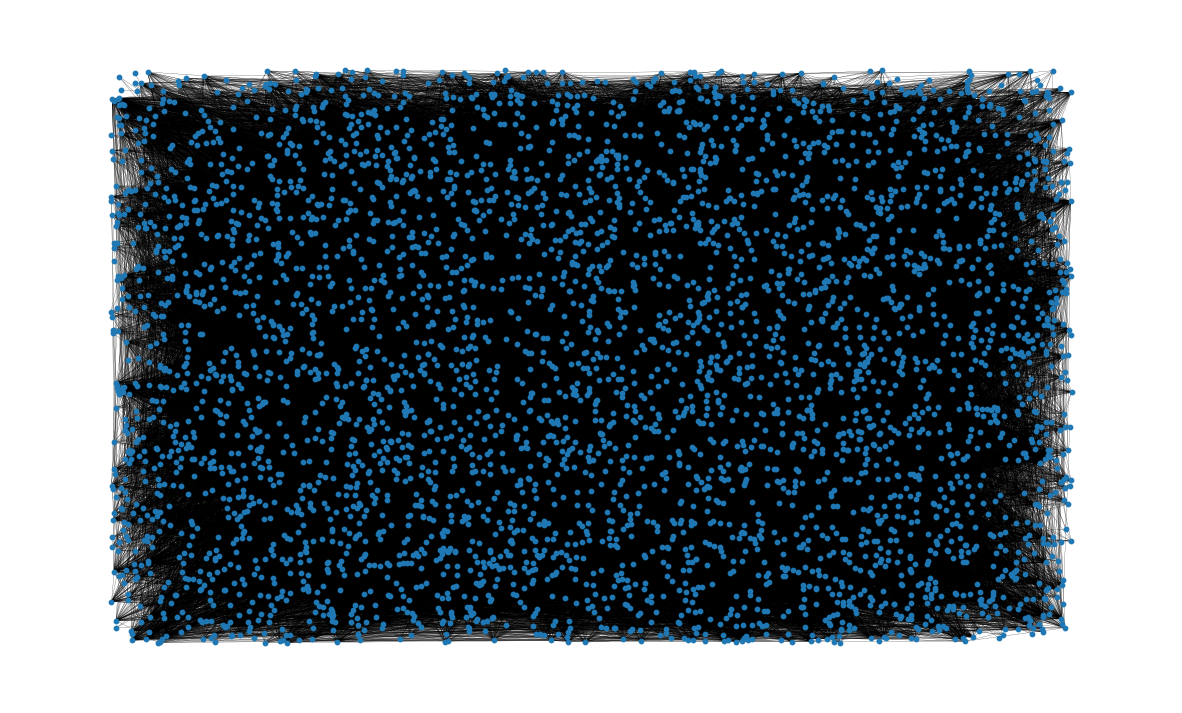

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

Do we need more or less information (nodes or edges) from the graph to do the analysis? Let's check `spring_layout` and continue analysis...

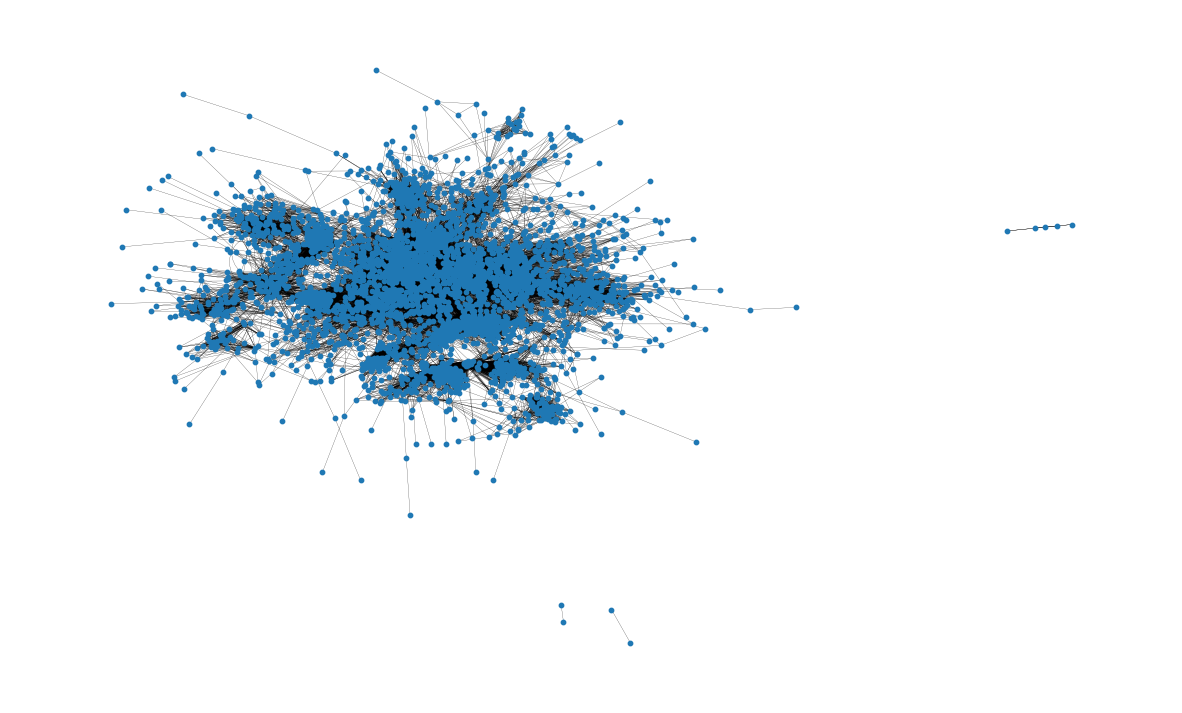

In [ ]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

What other information can we extract from this network? ... (check graphs metrics)

## Atributos básicos del grafo

In [4]:
G.number_of_nodes()

4316

In [5]:
G.number_of_edges()

58270

In [18]:
# average degree of a node
np.mean([d for _, d in G.degree()])

27.00185356811863

Este grafo tiene 4316 nodos y 58270 transacciones. En promedio, cada nodo está conectado a otros 27 nodos.

In [19]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

In [32]:
# Check if the graph is connected
if nx.is_connected(G):
    # If connected, calculate the diameter as before
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
    diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
    print("Diameter:", diameter)
else:
    # If not connected, print a message indicating the issue
    print("The graph is not connected. Diameter cannot be calculated.")

The graph is not connected. Diameter cannot be calculated.


In [33]:
connected_components = list(nx.connected_components(G))

In [34]:
len(connected_components)

7

In [35]:
# Process each connected component individually
for component in connected_components:
    subgraph = G.subgraph(component)
    edges = subgraph.number_of_edges()
    nodes = subgraph.number_of_nodes()
    print("Nodes of component:", nodes, "| Edges of component:", edges)

Nodes of component: 4143 | Edges of component: 57150
Nodes of component: 95 | Edges of component: 638
Nodes of component: 5 | Edges of component: 9
Nodes of component: 48 | Edges of component: 355
Nodes of component: 2 | Edges of component: 1
Nodes of component: 21 | Edges of component: 116
Nodes of component: 2 | Edges of component: 1


Se identifica que no es posible calcular el diámetro, medida que nos indica cuántas aristas tendríamos que atravesar como máximo para conectarnos de un nodo a cualquier otro dentro del grafo. Esto sucede porque el grafo tiene nodos que no están conectados, como se puede observar en la figura previamente generada con spring layout.

Por lo anterior, se calculan los subgrafos existentes y para cada uno de ellos se calcula la cantidad de nodos y aristas con el fin de enfocar el análisis del diámetro en el grafo principal, ignorándose aquellos subgrafos aislados compuestos por una cantidad minoritaria de  nodos.

In [38]:
#reemplazar G con la ifnormación del subgrafo principal
S = G.subgraph(connected_components[0])
S.number_of_nodes()

4143

In [39]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(S))

In [40]:
diameter = max(nx.eccentricity(S, sp=shortest_path_lengths).values())
diameter

16

En este subgrafo, para conetarnos de un nodo a cualquier otro dentro del subgrafo, tendríamos que atravesar 16 aristas o menos.

In [41]:
# Compute the average shortest path length for each node
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

4.959718427314503

La métrica de longitud promedio del camino nos indica que que para llegar de un nodo a otro, se atravesarán aproximadamente 5 aristas en promedio.

Text(0, 0.5, 'Frequency (%)')

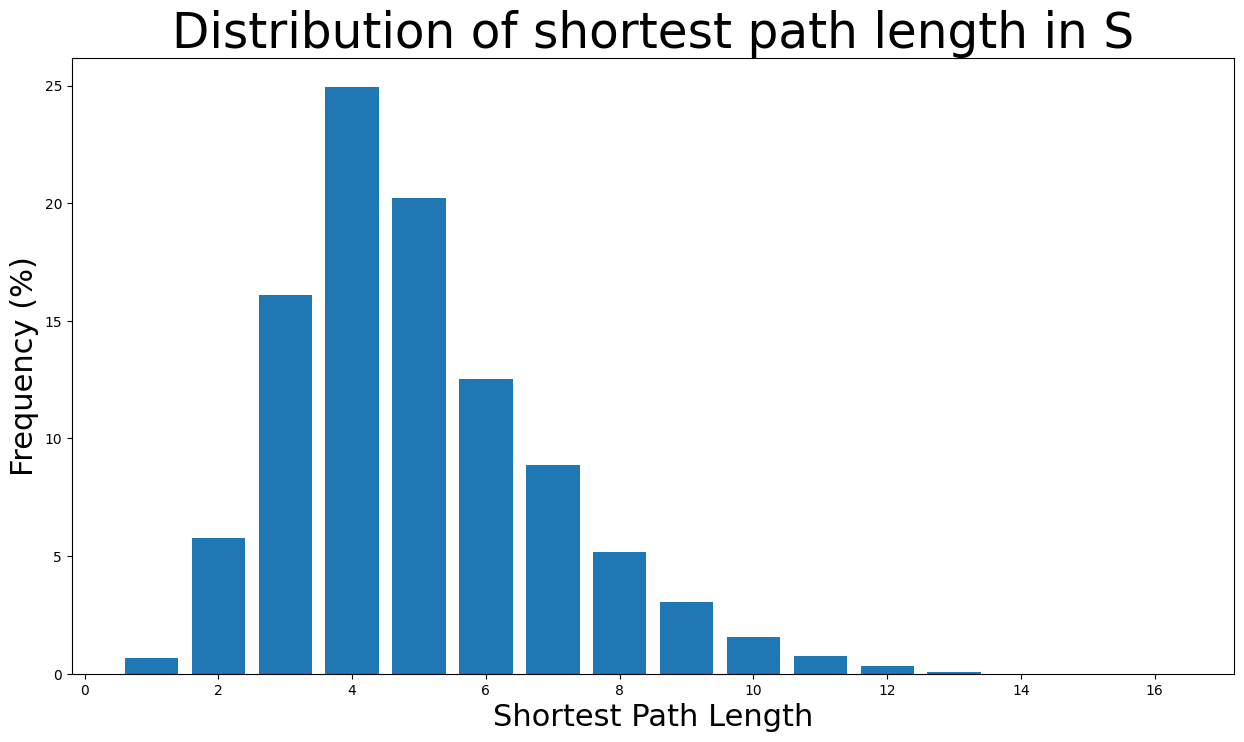

In [42]:
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribution of shortest path length in S", fontdict={"size": 35}, loc="center"
)
ax.set_xlabel("Shortest Path Length", fontdict={"size": 22})
ax.set_ylabel("Frequency (%)", fontdict={"size": 22})

La distribución de las longitudes de camino más cortas, nos indica que la mayoría de los caminos más cortos tienen entre 3 y 6 aristas de longitud. Además, es muy poco probable que un par de nodos tenga un camino más corto de longitud 16 (diámetro).

In [43]:
nx.density(S)

0.006660720385755359

La medida de densidad sugiere que el grafo es muy disperso, es decir, tiene relativamente pocas conexiones (sólo el 0.67%) en comparación con el número total posible de conexiones.

## Medidas de centralidad

In [ ]:
G = nx.from_pandas_edgelist(twitter, "start_node", "end_node")

In [ ]:
G.number_of_nodes()

4316

In [ ]:
degree_centrality = nx.centrality.degree_centrality(
    G
)  # save results in a variable to use again
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(48485771, 0.07022016222479723),
 (5442012, 0.06813441483198146),
 (3359851, 0.06581691772885284),
 (40981798, 0.06257242178447277),
 (43003845, 0.0593279258400927),
 (34428380, 0.056315179606025494),
 (22462180, 0.05608342989571263),
 (15913, 0.055851680185399766)]

En la celda anterior, se identificaron los 8 nodos con mayor grado de centralidad en el grafo. El grado de centralidad de un nodo es la fracción de nodos a los que está conectado. Como ejemplo, el nodo 48485771 es el que tiene mayor grado de centralidad (0,07). En términos de negocio, esto significa que este usuario de twitter tiene conexión con alrededor del 7% de toda la red.

In [ ]:
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:8]

[(48485771, 303),
 (5442012, 294),
 (3359851, 284),
 (40981798, 270),
 (43003845, 256),
 (34428380, 243),
 (22462180, 242),
 (15913, 241)]

En la celda anterior se puede observar directamente el número de nodos conectados a los 8 nodos con mayor grado de centralidad. El nodo 48485771 que es el más polular tiene conexión directa con 303 nodos.

Text(0, 0.5, 'Counts')

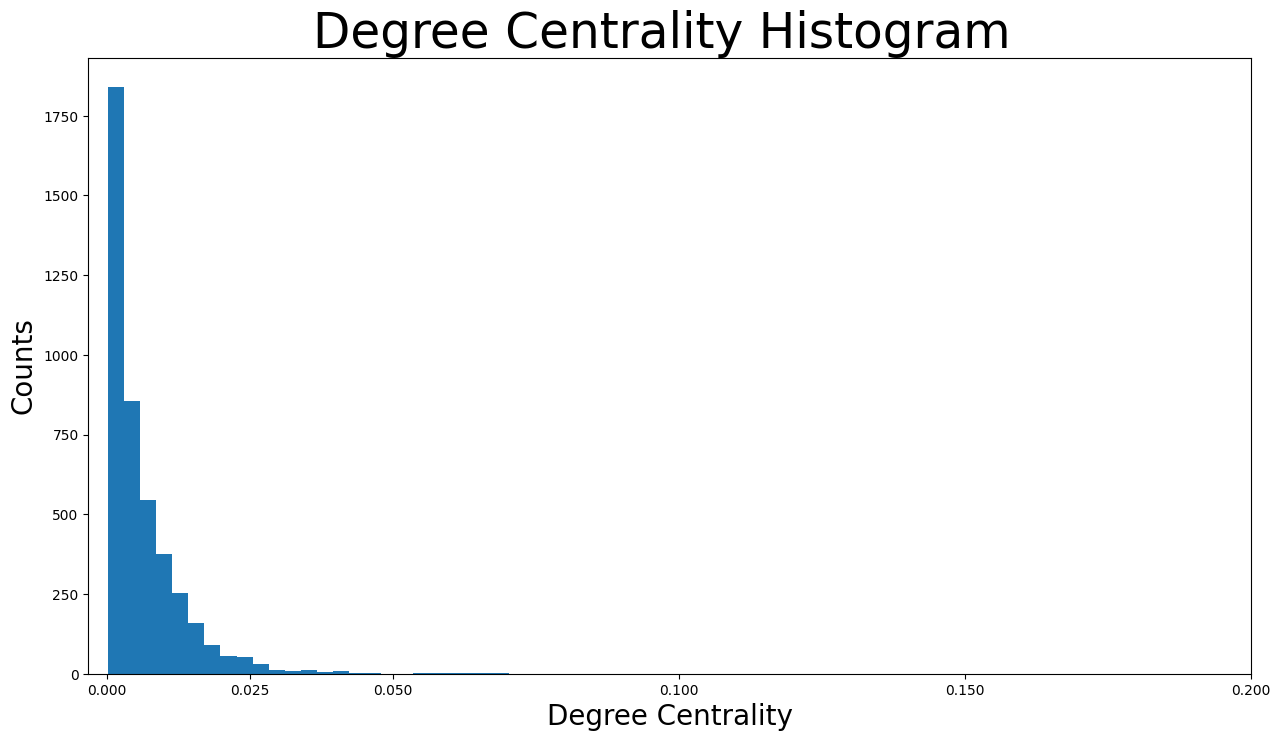

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

La distribución del grado de centralidad, nos permite concluir que la gran mayoría de usuarios tiene grados de centralidad menores al 1%. Esto es consistente con el hecho de que el grafo está construido a partir de un conjunto de datos que incluye características de ciertos perfiles y sus círculos y grafos de ego.

A continuación se pueden observar los usuarios según su grado centralidad, donde las centralidades más altas se representan con un mayor tamaño del nodo en la visualización:

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

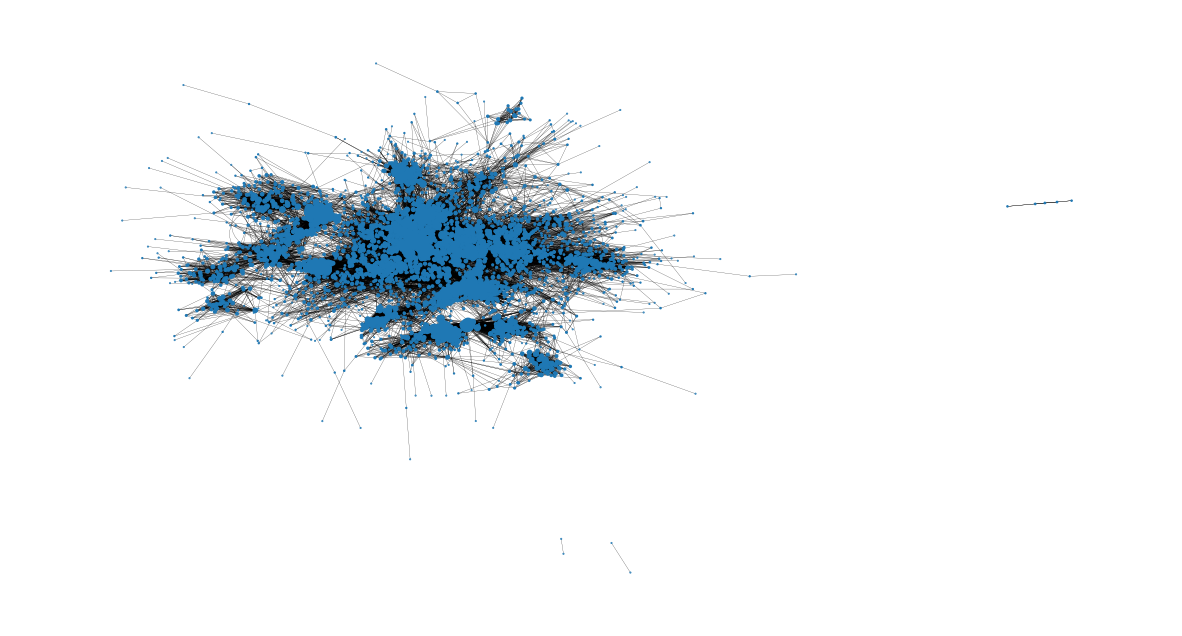

In [ ]:
node_size = [
    v * 1000 for v in degree_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Centralidad de Intermediación (Betweenness)

In [ ]:
betweenness_centrality = nx.centrality.betweenness_centrality(
    G
)  # save results in a variable to use again
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(6207392, 0.1725645640056724),
 (3359851, 0.15443758920551148),
 (783214, 0.0975291202117271),
 (41716273, 0.09272687817377762),
 (17093617, 0.09073724589851986),
 (27634404, 0.08587007531097253),
 (15666380, 0.07953763787324364),
 (48485771, 0.05738734697388068)]

En la celda anterior se listan los 8 nodos con grados más altos de intermediación en el grafo. Esto significa que estos nodos sirven como intermediario en muchas de las rutas más cortas entre pares de otros nodos.

El usuario con mayor grado de intermediación es el 6207392, lo que significa que se encuentra en el 17% del total de caminos más cortos entre otros nodos.

En el contexto de Twitter, estos usuarios con alta centralidad de intermediación conectan diferentes comunidades o grupos de usuarios, por lo tanto son claves para la difusión de información entre segmentos de la red que normalmente no interactúan.

Text(0, 0.5, 'Counts')

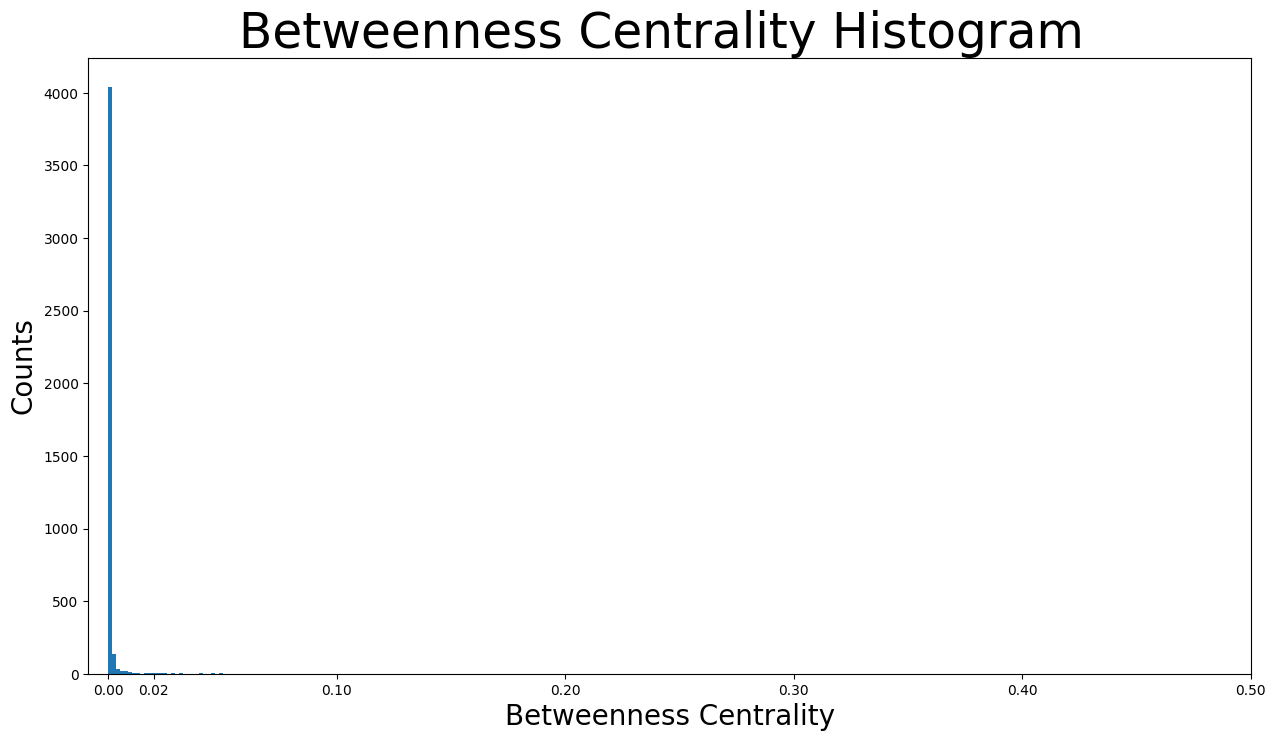

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  # set the x axis ticks
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

La distribución del grado de centralidad, nos permite concluir que la gran mayoría de usuarios tiene un grado de intermediación del 2%. Es decir, hay muy pocos usuarios en la red cuya presencia o ausencia pueda afectar significativamente la estructura y el comportamiento de la red en su conjunto.

A continuación se pueden observar los usuarios según su grado centralidad de intermediación, donde las intermediaciones más altas se representan con un mayor tamaño del nodo en la visualización:

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

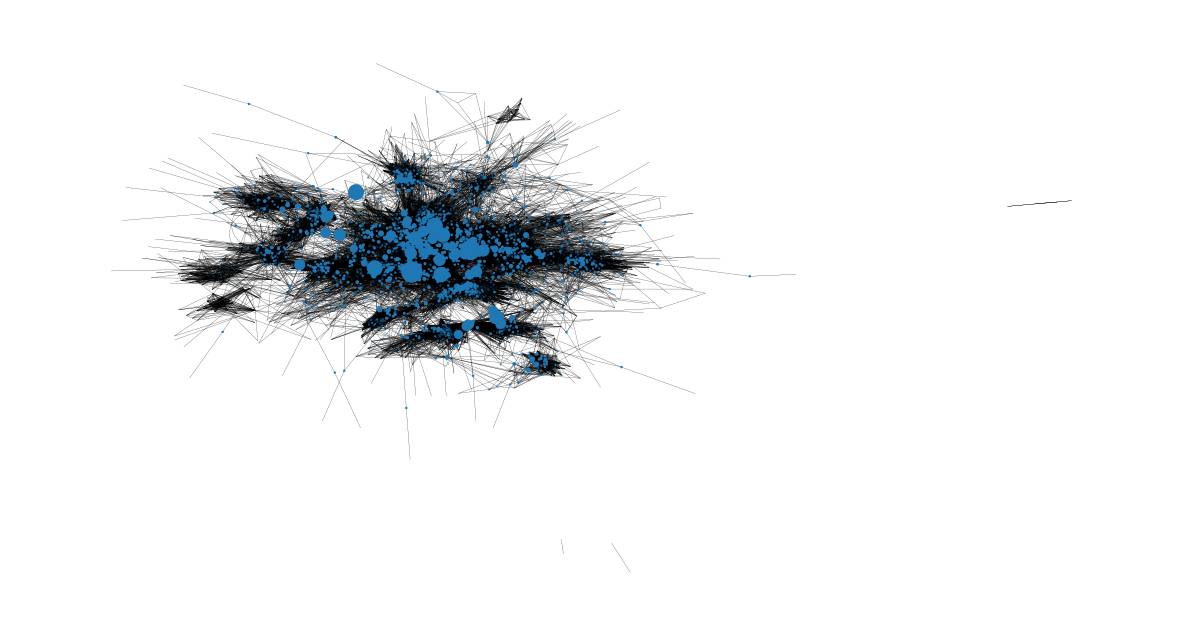

In [ ]:
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Centralidad de cercanía (Closeness)

In [ ]:
closeness_centrality = nx.centrality.closeness_centrality(
    G
)  # save results in a variable to use again
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(3359851, 0.3174907000782523),
 (15234657, 0.2989200839846593),
 (48485771, 0.2947102540271258),
 (7860742, 0.293730499193259),
 (15666380, 0.2907448655999966),
 (20880546, 0.29061735524303445),
 (3829151, 0.2868847706962951),
 (115485051, 0.2850950836856413)]

En la celda anterior se listan los 8 nodos con grados más altos de centralidad de cercanía en el grafo. Esto significa que estos nodos están, en promedio, a menor distancia de todos los demás nodos en la red y por lo tanto pueden acceder rápidamente a cualquier otro nodo.

El usuario con mayor grado de centralidad de cercanía es el 3359851. En el contexto de twitter, este usuario tiene la mayor ventaja en la difusión de información o en la velocidad de comunicación dentro de la red puesto que su distancia promedio a todos los demás nodos es del 31.7% de la distancia máxima posible.

Text(0, 0.5, 'Counts')

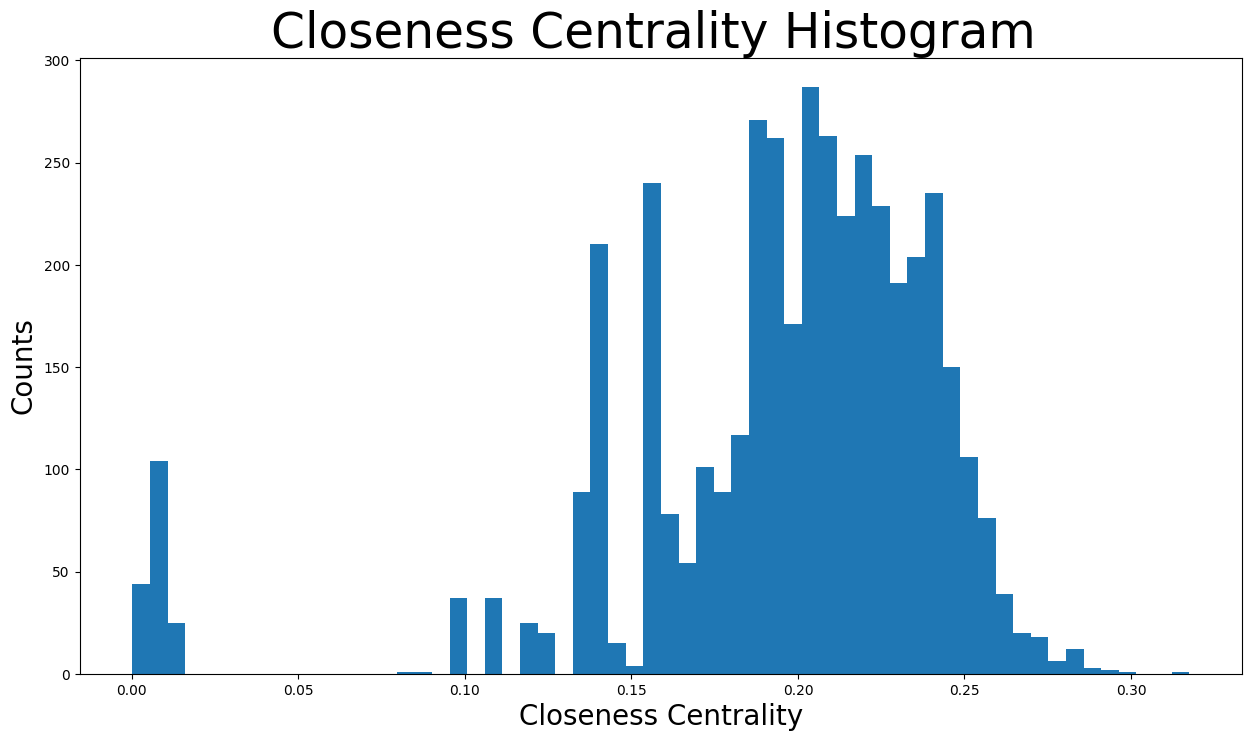

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("Closeness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

La distribución nos permite concluir que la mayoría de grados de centralidad de cercanía están entre el 15% y el 25%, indicando que, en general, los nodos están relativamente cerca de los demás nodos de la red.

A continuación se pueden observar los usuarios según su grado centralidad de cercanía, donde los grados más altos se representan con un mayor tamaño del nodo en la visualización:

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

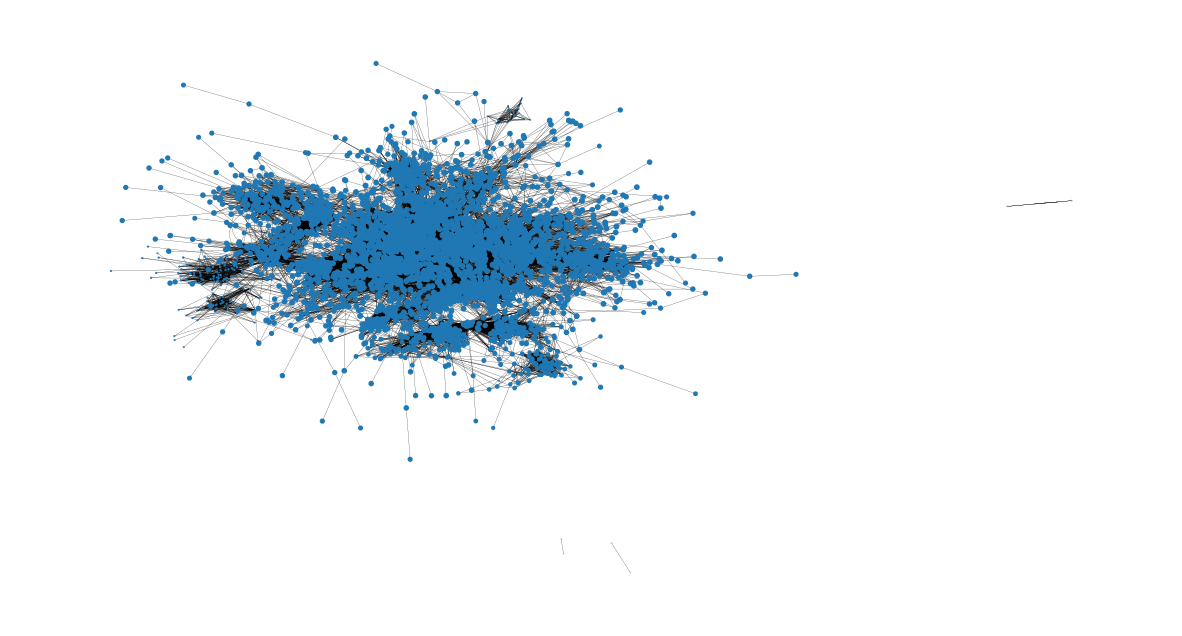

In [ ]:
node_size = [
    v * 50 for v in closeness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Centralidad de vector propio (Eigenvector)

In [ ]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(
    G
)  # save results in a variable to use again
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(40981798, 0.15363590744821665),
 (43003845, 0.1507372702636457),
 (22462180, 0.14898138833635383),
 (34428380, 0.14836888505482648),
 (153226312, 0.11747403879993272),
 (270449528, 0.11544891170259039),
 (83943787, 0.11509706228160357),
 (17868918, 0.11470184783932444),
 (151338729, 0.11429285736480958),
 (279787626, 0.1140975626333083)]

En la celda anterior se listan los 10 nodos con grados más altos de centralidad de vector propio. Esta medida indica que uno nodo no sólo es importante por sus conexiones directas, sino porque también está conectado a otros nodos que, a su vez, son influyentes dentro de la red.

Se puede observar que los nodos 40981798 y 4300384 presentan un grado de centralidad de vector propio del 15%. Esto significa que son los usuarios que están en una posición de prestigio o influencia al vincularse con otros nodos clave en la red.

Text(0, 0.5, 'Counts')

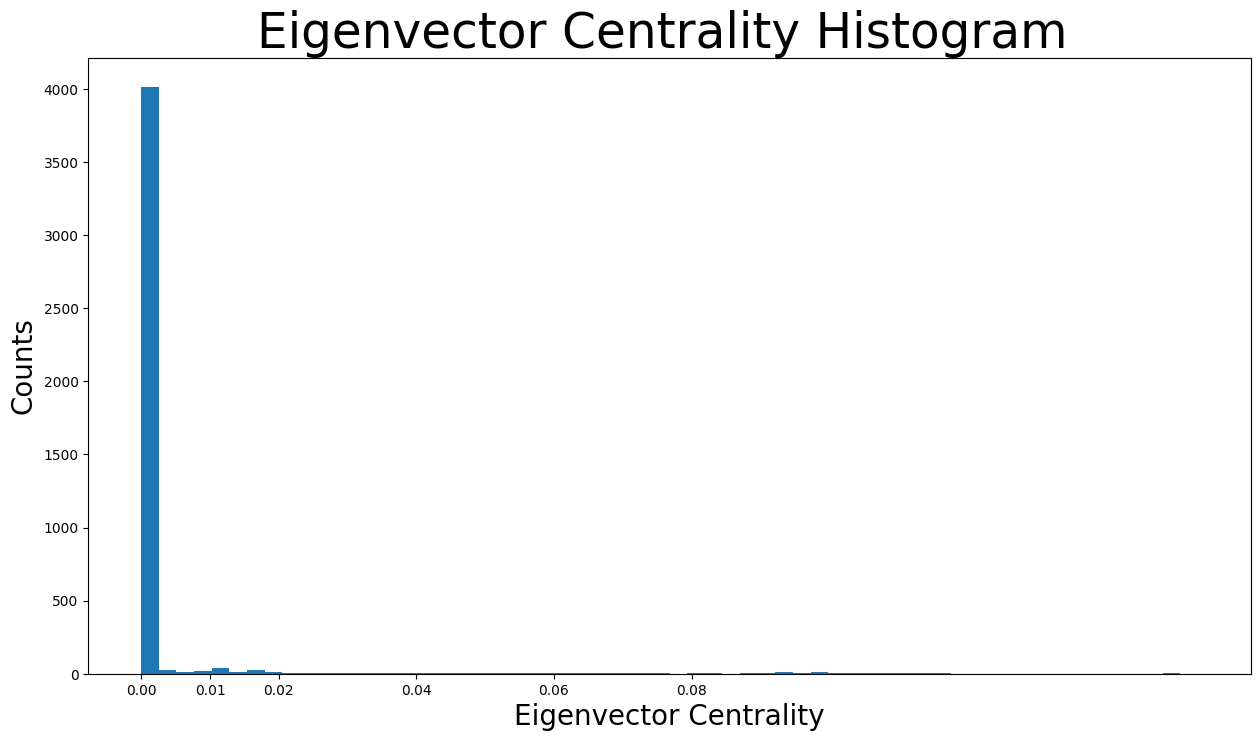

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)
plt.xticks(ticks=[0, 0.01, 0.02, 0.04, 0.06, 0.08])  # set the x axis ticks
plt.title("Eigenvector Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Eigenvector Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

La distribución nos permite concluir que la mayoría de grados de centralidad de vector propio está entre 0 y 0.005, lo que sugiere que, en general, los nodos de la red están conectados a otros nodos de baja influencia y sólo unos pocos nodos están bien conectados con otros nodos influyentes.

A continuación se pueden observar los usuarios según su grado centralidad de vector propio, donde los grados más altos se representan con un mayor tamaño del nodo en la visualización

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

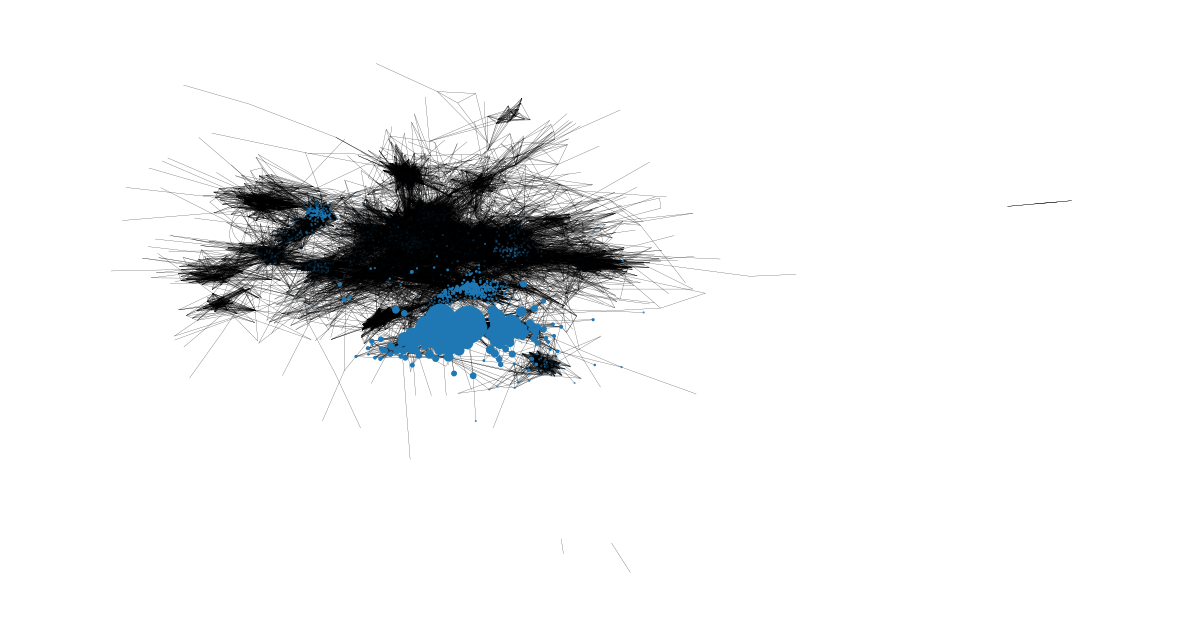

In [ ]:
node_size = [
    v * 4000 for v in eigenvector_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

## Clustering

In [ ]:
nx.average_clustering(G)

0.4949716847236492

Este coeficiente indica que el grafo tiene un nivel moderado de agrupamiento. En promedio, el 49.5% de los vecinos de un nodo también están conectados entre sí, formando triángulos o pequeñas comunidades.

Esto sugiere que la red tiene cierta cohesión local, con una tendencia de los nodos a agruparse, aunque no completamente.

Text(0, 0.5, 'Counts')

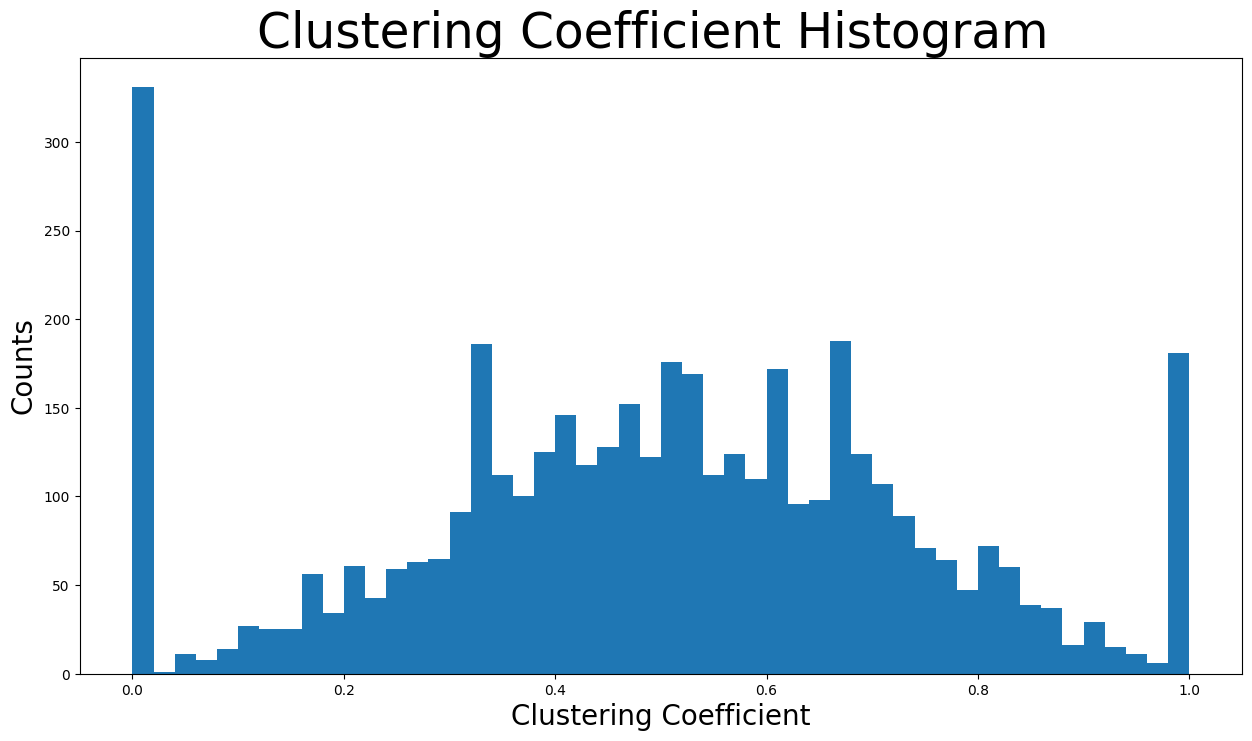

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50)
plt.title("Clustering Coefficient Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Clustering Coefficient", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Este diagrama de distribución nos permite identificar que:
- Hay una cantidad signficativa de nodos con un coeficiente de agrupamiento de 0, lo que significa que muchos nodos no forman triángulos ni están en grupos cohesionados.

- La mayoría de nodos están presentan coeficientes de agrupamiento entre 0.4 y 0.6. Esto indica que algunos nodos tienen una moderada tendencia a formar grupos.

- Hay una pequeña cantidad de nodos con un coeficiente de agrupamiento de 1, lo que significa que esos nodos están en comunidades donde todos sus vecinos están completamente conectados entre sí.

In [ ]:
triangles_per_node = list(nx.triangles(G).values())
sum(
    triangles_per_node
) / 3  # divide by 3 because each triangle is counted once for each node

465759.0

En la red hay un total de 465759 triágulos

In [ ]:
np.mean(triangles_per_node)

323.7435125115848

En promedio, un nodo forma parte de 323 tríangulos.

In [ ]:
np.median(triangles_per_node)

71.0

Si tenemos en cuenta la mediana, en lugar del promedio, podemos identificar que un nodo típico en la red participa en 71 triángulos.

## Bridges

In [ ]:
nx.has_bridges(G)

True

In [ ]:
bridges = list(nx.bridges(G))
len(bridges)

209

Las celdas anteriores nos indican que la red tiene puentes. Existen en total 209 conexiones críticas cuya eliminación dividiría el grafo en componentes separados.

In [ ]:
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)

987

Existen 987 puentes locales. Un puente local une dos aristas cuyos puntos finales no tienen amigos en común. En esta lista también contiene todos los puentes anteriores, puesto que una arista que es un puente es también un puente local.

A continuación, se dibujan los puentes con color rojo y los puentes locales con el color verde.

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

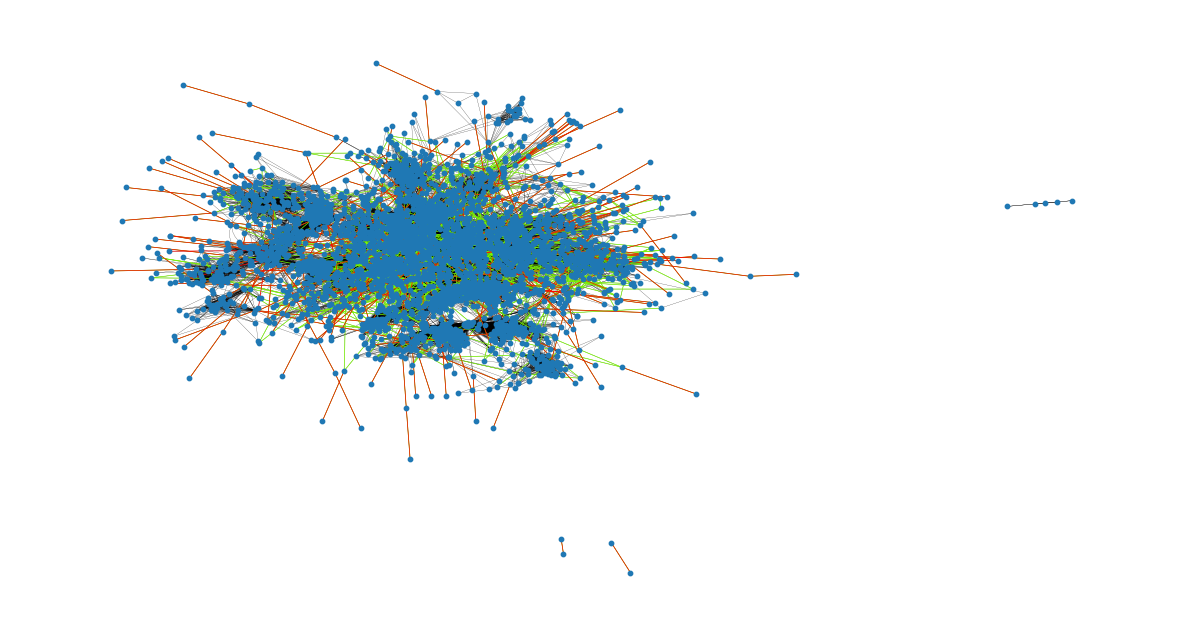

In [ ]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)  # green color for local bridges
nx.draw_networkx_edges(
    G, pos, edgelist=bridges, width=0.5, edge_color="r"
)  # red color for bridges
plt.axis("off")

Se identifica que la cantidad de puentes es alta. Se puede concluir que que la estructura de la red es vulnerable, ya que depende de estas conexiones para mantener la cohesión entre los nodos. Esto podría reflejar que la red de twitter que se está analizando tiene comunidades menos integradas y más susceptibles a fragmentarse.

## Assortativity

In [ ]:
nx.degree_assortativity_coefficient(G)

0.07572773506976808

In [ ]:
nx.degree_pearson_correlation_coefficient(
    G
)  # use the potentially faster scipy.stats.pearsonr function.

0.07572773506976584

Partiendo de que la asortatividad se mide entre -1 y 1, el coeficiente de asortatividad de 0.075 indica que no hay una correlación marcada según el grado de los nodos, por lo que podemos inferir que en esta red de twitter, los usuarios no siguen a otros de manera selectiva según su popularidad. En lugar de formar grupos de usuarios con similar influencia, las relaciones son más dispersas y diversas.

###Network Communities

In [ ]:
G.number_of_nodes()

4316

In [11]:
colors = {node: "" for node in G.nodes()}  # Inicializa todos los nodos con un valor vacío o predeterminado
counter = 0

for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # Crea un color RGB aleatorio
    counter += 1
    for node in com:
        colors[node] = color  # Asigna un color específico a cada nodo de la comunidad

counter

88

In [14]:
#convertir colors a una lista nuevamente
colors = list(colors.values())
len(colors)

4316

Aplicando el método "semi-synchronous label propagation", se identificaron 88 posibles comunidades en el grafo, que se muestran a continuación diferenciadas por colores:

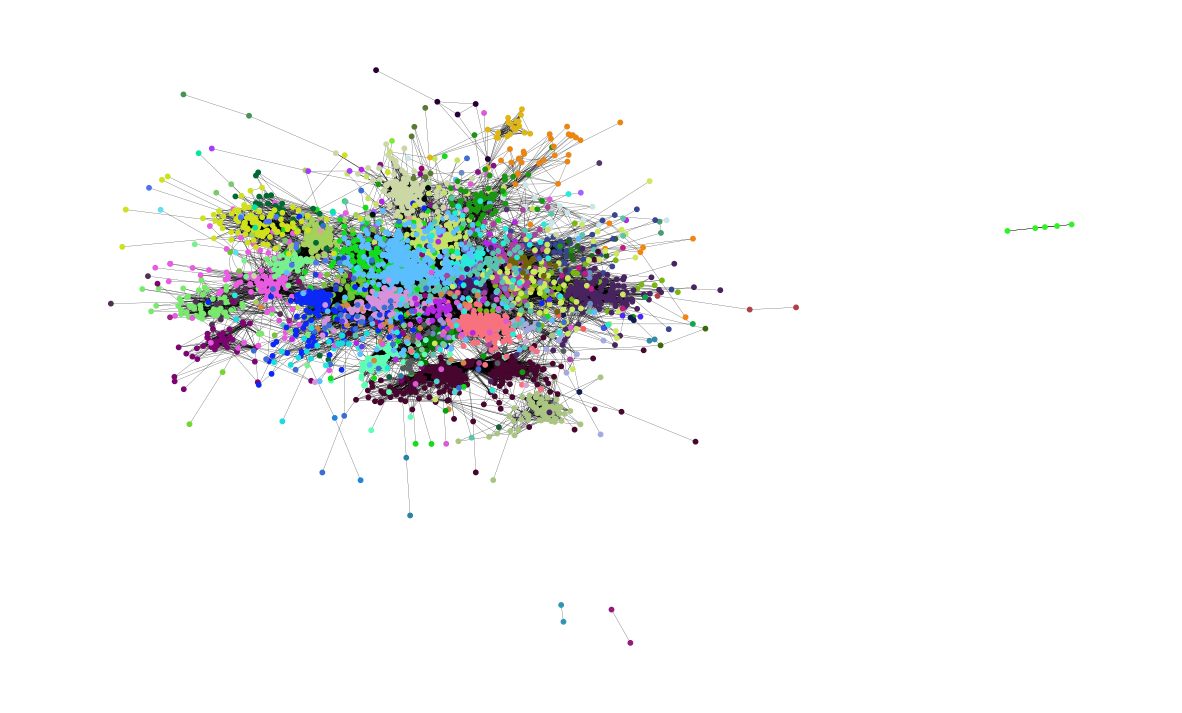

In [15]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)

Ahora, teniendo en cuenta que, para aplicar el algoritmo "asynchronous fluid communities" el grafo debe estar completamente conectado. El calculo de comunidades en este caso se aplica para cada uno de los subgrafos:

In [69]:
# Initialize colors dictionary for all nodes
colors = {node: "" for node in G.nodes()}

# Iterate through each connected component and apply the algorithm
for component in range(0, len(connected_components)):
    # Induce a subgraph for the current component
    subgraph = G.subgraph(connected_components[component])

    if component == 0:
      k = 7
    else:
     k = 1

    # Apply the asyn_fluidc algorithm to the subgraph
    for com in nx.community.asyn_fluidc(subgraph, k, seed=0):
        color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
        for node in list(com):
            colors[node] = color

# Now 'colors' dictionary contains color assignments for all nodes in the original graph

In [70]:
#convertir colors a una lista nuevamente
colors = list(colors.values())
len(colors)

4316


En este caso, le indicamos crear 7 comunidades en el subgrafo principal que ya habíamos analizado al inicio del notebook y tiene 4143 de los 4316 nodos de la red completa. Para los subgrafos más pequeños se determina una sola comunidad por subgrafo.

A continuación, se muestran las comunidades diferenciadas por colores:

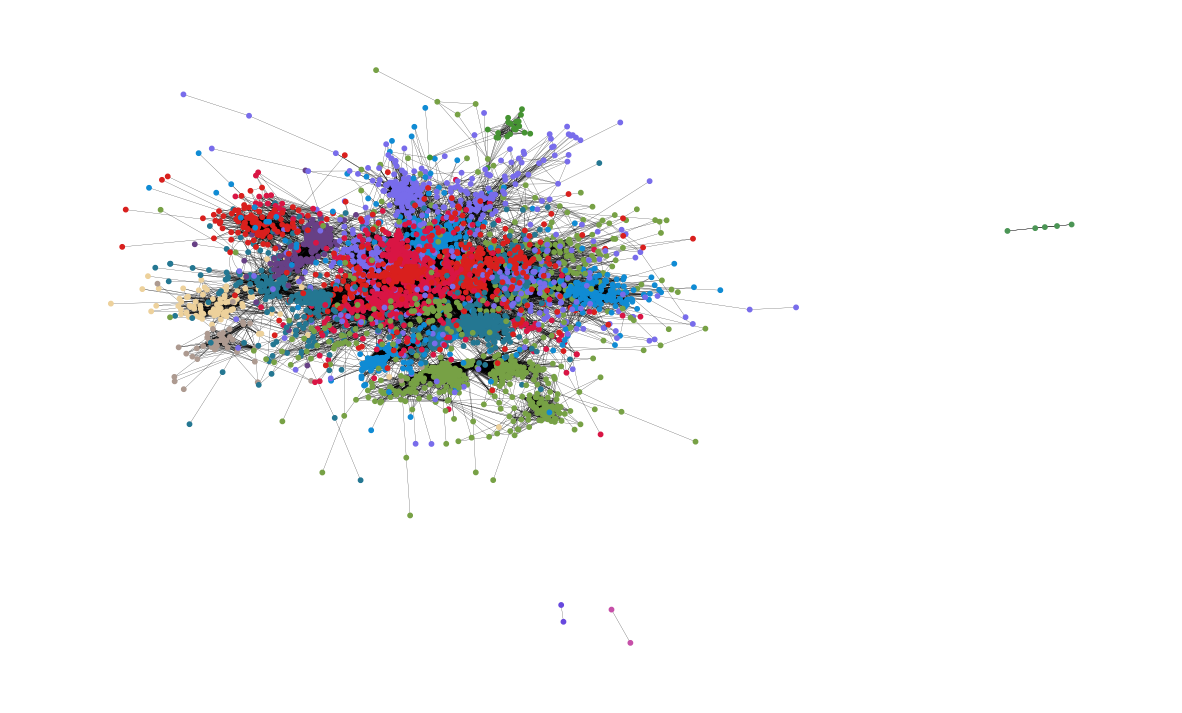

In [71]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)